### 基于关联规则算法实现电影推荐系统
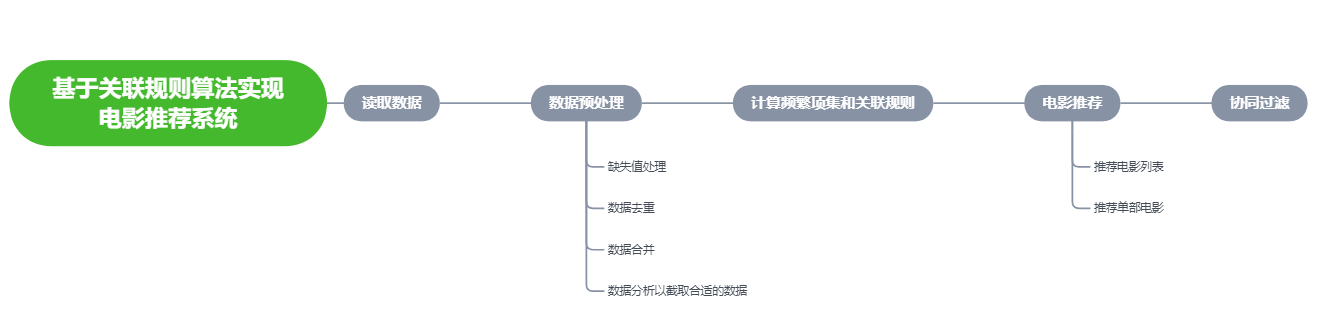
- 利用数据挖掘算法中的Apriori(关联规则)算法来实现一个电影推荐系统
  - 加载数据
  - 数据预处理
  - 生成频繁项集、关联规则
- 通过关联规则生成电影推荐的列表

### Apriori算法
- **案例：** 
 啤酒与尿布:  沃尔玛超市在分析销售记录时，发现了啤酒与尿布经常一起被购买，于是他们调整了货架将两者放在了一起，结果真的提升了啤酒的销量。  原因解释: 爸爸在给宝宝买尿布的时候，会顺便给自己买点啤酒？
- **概述：**
 Apriori算法是一种最有影响力的挖掘布尔关联规则的频繁项集的算法，其命名Apriori源于算法使用了频繁项集性质的先验(Prior)知识。
 接下来我们将以超市订单的例子理解关联分析相关的重要概念: Support(支持度)、Confidence(置信度)、Lift(提升度）。
 
  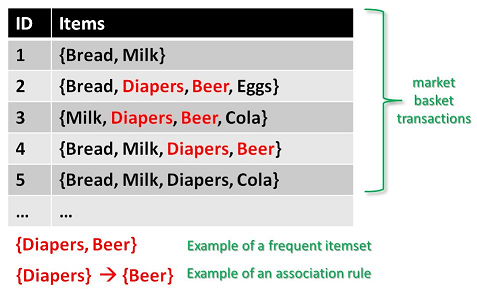
  
  - Support(支持度)：指某事件出现的概率，在本例中即指某个商品组合出现的次数占总次数的比例。
  
  例：Support('Bread') = 4/5 = 0.8 Support('Milk') = 4/5 = 0.8
     Support('Bread+Milk') = 3/5 = 0.6  
     
  - Confidence(置信度)：本质上是个条件概率，即当购买了商品A的前提下，购买商品B的概率。
  
  例：Confidence('Bread'—> 'Milk') = Support('Bread+Milk')/ Support('Bread') = 0.6/0.8 = 0.75  
  
  - Lift(提升度）: 指商品A的出现，对商品B的出现的概率的提升程度。Lift(A->B) = Confidence(A, B) / Support(B)
  
  例：Lift('Bread'—> 'Milk') = 0.75/0.8 = 0.9375 

- **对于Lift(提升度）有三种情况：**
  - Lift(A->B)>1: 代表A对B的出现概率有提升。
  - Lift(A->B)=1: 代表A对B的出现概率没有提升，也没有下降。
  - Lift(A->B)<1: 代表A对B的出现概率有下降效果。
  
- **原理：**
 该算法挖掘关联规则的过程，即是查找频繁项集(frequent itemset)的过程:
   - 频繁项集：支持度大于等于最小支持度(Min Support)阈值的项集。
   - 非频繁集：支持度小于最小支持度的项集。

- **流程：**
 K = 1, 计算K项集的支持度；
 筛选掉小于最小支持度的项集；
 如果项集为空，则对应K-1项集的结果为最终结果。否则K = K+1重复2-3步

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend
import numpy as np

#### 电影数据准备

In [2]:
movie_data_file = './movie_dataset/movies_metadata.csv'
ratings_file = './movie_dataset/ratings_small.csv'

In [3]:
movie_data_df = pd.read_csv(movie_data_file)
ratings_df = pd.read_csv(ratings_file)

/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
movie_data_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
movie_data_df.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [6]:
movie_data_df.info

<bound method DataFrame.info of        adult                              belongs_to_collection    budget  \
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      False                                                NaN  65000000   
2      False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3      False                                                NaN  16000000   
4      False  {'id': 96871, 'name': 'Father of the Bride Col...         0   
...      ...                                                ...       ...   
45461  False                                                NaN         0   
45462  False                                                NaN         0   
45463  False                                                NaN         0   
45464  False                                                NaN         0   
45465  False                                                NaN         0   

                                           

In [7]:
movie_data_df.count()

adult                    45466
belongs_to_collection     4494
budget                   45466
genres                   45466
homepage                  7782
id                       45466
imdb_id                  45449
original_language        45455
original_title           45466
overview                 44512
popularity               45461
poster_path              45080
production_companies     45463
production_countries     45463
release_date             45379
revenue                  45460
runtime                  45203
spoken_languages         45460
status                   45379
tagline                  20412
title                    45460
video                    45460
vote_average             45460
vote_count               45460
dtype: int64

In [8]:
movie_data_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [9]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [11]:
ratings_df.count()

userId       100004
movieId      100004
rating       100004
timestamp    100004
dtype: int64

In [12]:
ratings_df.shape

(100004, 4)

In [13]:
movie_data_df.shape

(45466, 24)

#### 数据预处理
- 缺失值处理
- 数据去重
- 电影源信息 merge 电影评分信息

In [39]:
movie_data_df_t=movie_data_df[['title','id']]

In [40]:
movie_data_df_t.dtypes

title    object
id       object
dtype: object

In [41]:
ratings_df_s = ratings_df.drop(['timestamp'], axis=1)  #axis=0 跨列删除行 ，axis=1 跨行删除列

In [42]:
ratings_df_s.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

##### 缺失值处理
- pandas中用NaN(Not a Number)表示浮点数和非浮点数数组中的缺失值，同时python中None值也被当作缺失值。

In [43]:
# pd.to_numeric 将id列 的数据 由字符串转为数值类型， 不能转换的数据设置为NaN
pd.to_numeric(movie_data_df_t['id'],errors='coerce')

0           862.0
1          8844.0
2         15602.0
3         31357.0
4         11862.0
           ...   
45461    439050.0
45462    111109.0
45463     67758.0
45464    227506.0
45465    461257.0
Name: id, Length: 45466, dtype: float64

In [44]:
#np.where返回满足（）内条件的数据所在的位置
np.where(pd.to_numeric(movie_data_df_t['id'], errors='coerce').isna()) #返回缺失值的位置，其中isna() 对于NaN返回True，否则返回False

(array([19730, 29503, 35587]),)

- **loc works on labels in the index.**
  - loc为Selection by Label函数，即为按标签取数据，标签是什么，就是上面的’0’~‘4’, ‘A’~‘B’。
  - 例如第一个参数选择index，第二个参数选择column 
  - 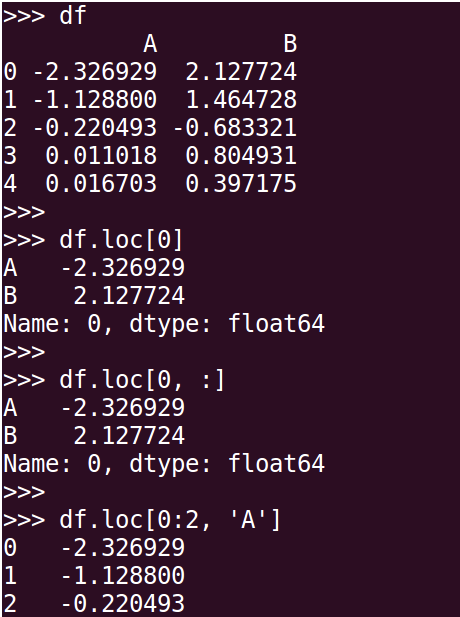
  - 建议写df.loc[0, :]，这样可以清楚的看出为第0行的所有记录，同样如果取第’A’列的所有记录，可以写df.loc[:, ‘A’]，如下图：
  - 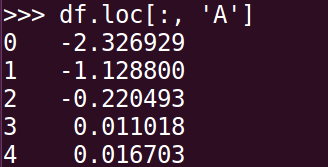
  - :表示所有，[]里边为先行后列
- **iloc works on the positions in the index (so it only takes integers).**
  - iloc函数为Selection by Position，即按位置选择数据，即第n行，第n列数据，只接受整型参数, 比如 0:2为左闭右开区间，即取0，1
  - 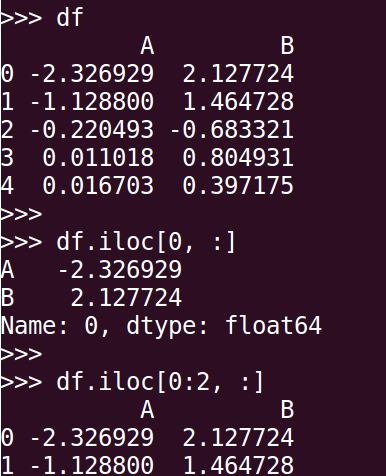
  - 若要取第一列的所有数据，则为df.iloc[:, 0]，不接受’A’作为参数
  - 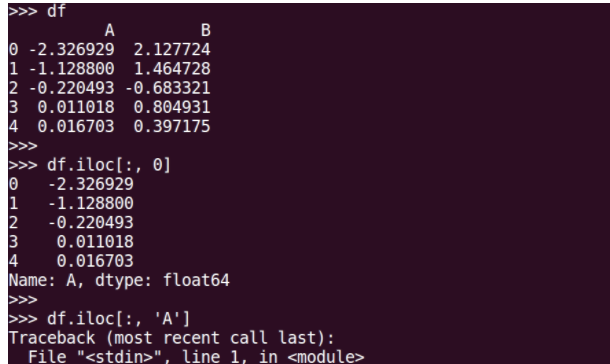

In [45]:
movie_data_df_t.iloc[19730]

title           NaN
id       1997-08-20
Name: 19730, dtype: object

In [46]:
movie_data_df_t.iloc[[19730,29503,35587]]

,title,id
19730,NaN,1997-08-20
29503,NaN,2012-09-29
35587,NaN,2014-01-01


In [47]:
# 将格式转换后的数据 赋值给id列
movie_data_df_t['id'] = pd.to_numeric(movie_data_df_t['id'], errors='coerce')

/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
movie_data_df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   45460 non-null  object 
 1   id      45463 non-null  float64
dtypes: float64(1), object(1)
memory usage: 710.5+ KB


In [49]:
movie_data_df_t.iloc[[19730,29503,35587]]

,title,id
19730,NaN,NaN
29503,NaN,NaN
35587,NaN,NaN


In [50]:
movie_data_df_t.shape

(45466, 2)

In [51]:
movie_data_df_t.drop(np.where(movie_data_df_t['id'].isna())[0], inplace=True)

/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
movie_data_df_t.shape

(45463, 2)

##### 数据去重

In [53]:
movie_data_df_t.duplicated(['id','title']).sum()

30

In [54]:
movie_data_df_t.drop_duplicates(['id'],inplace=True)

/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
movie_data_df_t.shape

(45433, 2)

In [56]:
ratings_df_s.duplicated(['userId','movieId']).sum()

0

In [57]:
movie_data_df_t['id'] = movie_data_df_t['id'].astype(np.int64)

/Users/gaozhiyong/Documents/pyenv/pyenv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
movie_data_df_t.dtypes

title    object
id        int64
dtype: object

In [59]:
ratings_df_s.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

### 数据合并

In [60]:
# 左dataframe 和 右dataframe 根据 movieId 和 id进行合并
ratings_df_s = pd.merge(ratings_df_s,movie_data_df_t, left_on='movieId',right_on='id')

In [61]:
ratings_df_s.head()

,userId,movieId,rating,title,id
0,1,1371,2.5,Rocky III,1371
1,4,1371,4.0,Rocky III,1371
2,7,1371,3.0,Rocky III,1371
3,19,1371,4.0,Rocky III,1371
4,21,1371,3.0,Rocky III,1371


In [63]:
ratings_df_s.drop(['id'],axis=1,inplace=True)

In [64]:
ratings_df_s

,userId,movieId,rating,title
0,1,1371,2.5,Rocky III
1,4,1371,4.0,Rocky III
2,7,1371,3.0,Rocky III
3,19,1371,4.0,Rocky III
4,21,1371,3.0,Rocky III
...,...,...,...,...
44984,652,129009,4.0,Love Is a Ball
44985,653,2103,3.0,Solaris
44986,659,167,4.0,K-PAX
44987,659,563,3.0,Starship Troopers


In [65]:
ratings_df_s.shape

(44989, 4)

In [66]:
# 有评分记录的电影的个数
len(ratings_df_s['title'].unique())

2794

In [67]:
ratings_df_s['title'].unique()

array(['Rocky III', 'Greed', 'American Pie', ..., 'K-PAX',
       'Starship Troopers', 'Spirited Away'], dtype=object)

In [79]:
ratings_df_s.groupby([ratings_df_s['title'],ratings_df_s['rating']]).count().reset_index()

,title,rating,userId,movieId
0,!Women Art Revolution,3.0,1,1
1,!Women Art Revolution,3.5,1,1
2,'Gator Bait,0.5,1,1
3,'Twas the Night Before Christmas,3.5,1,1
4,'Twas the Night Before Christmas,4.5,1,1
...,...,...,...,...
10263,À nos amours,4.0,5,5
10264,À nos amours,4.5,1,1
10265,À nos amours,5.0,1,1
10266,Ödipussi,4.5,1,1
